In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
    library(googlesheets)
}))


In [2]:
gs_token <- "/home/users/ytanigaw/.googlesheets_token.rds"
gs_auth(token = gs_token)

'https://docs.google.com/spreadsheets/d/1gwzS0SVZBSKkkHgsoqB5vHo5JpUeYYz8PK2RWrHEq3A' %>%
gs_url() %>% 
gs_read(
    ws = 'GBE_names',
    col_types = cols('Units_of_measurement' = col_character())
) %>%
select(-GBE_short_name_len) -> GBE_names_df


Auto-refreshing stale OAuth token.

Sheet-identifying info appears to be a browser URL.
googlesheets will attempt to extract sheet key from the URL.

Putative key: 1gwzS0SVZBSKkkHgsoqB5vHo5JpUeYYz8PK2RWrHEq3A

Warning message:
“`data_frame()` is deprecated as of tibble 1.1.0.
Please use `tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Sheet successfully identified: "GBE_names"

Warning message:
“`as_data_frame()` is deprecated as of tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Accessing worksheet titled 'GBE_names'.



In [3]:
# input
FinnGen_annot_f <- '/scratch/groups/mrivas/public_data/summary_stats/finngen_r3/summary_stats/r3_manifest.tsv'
LDSC_rg_f <- '/oak/stanford/groups/mrivas/public_data/summary_stats/finngen_r3/UKB_WB_rg.20200722-093650.tsv.gz' # this file is copied
# from /scratch/groups/mrivas/public_data/summary_stats/finngen_r3/ldsc/UKB_WB_rg.20200722-093650/LDSC.rg.tsv.gz

# output
out_f <- '/oak/stanford/groups/mrivas/public_data/summary_stats/finngen_r3/UKB_WB_rg.20200722-093650.filtered.tsv'
plot_f <- '11_LDSC_rg_dist.png'


In [4]:
FinnGen_annot_f %>%
fread() %>%
select(-path_bucket, -path_https) -> FinnGen_df


In [5]:
LDSC_rg_f %>%
fread() %>%
rename('p1'='#p1') %>%
rename('phenocode'='p1', 'GBE_ID'='p2') %>%
drop_na(rg) -> df


In [6]:
p_LDSC_p <- df %>%
ggplot(aes(x=-log10(p))) +
geom_vline(xintercept=-log10(5e-2), color='red')+
geom_vline(xintercept=-log10(5e-5), color='red')+
geom_histogram(bins=30) +
theme_bw() +
xlim(0, 10) +
labs(
    title=latex2exp::TeX('$-\\log_{10}(p)$ from LDSC rg'),
    x=latex2exp::TeX('$-\\log_{10}(p)$')
)


Warning message:
“Removed 922 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


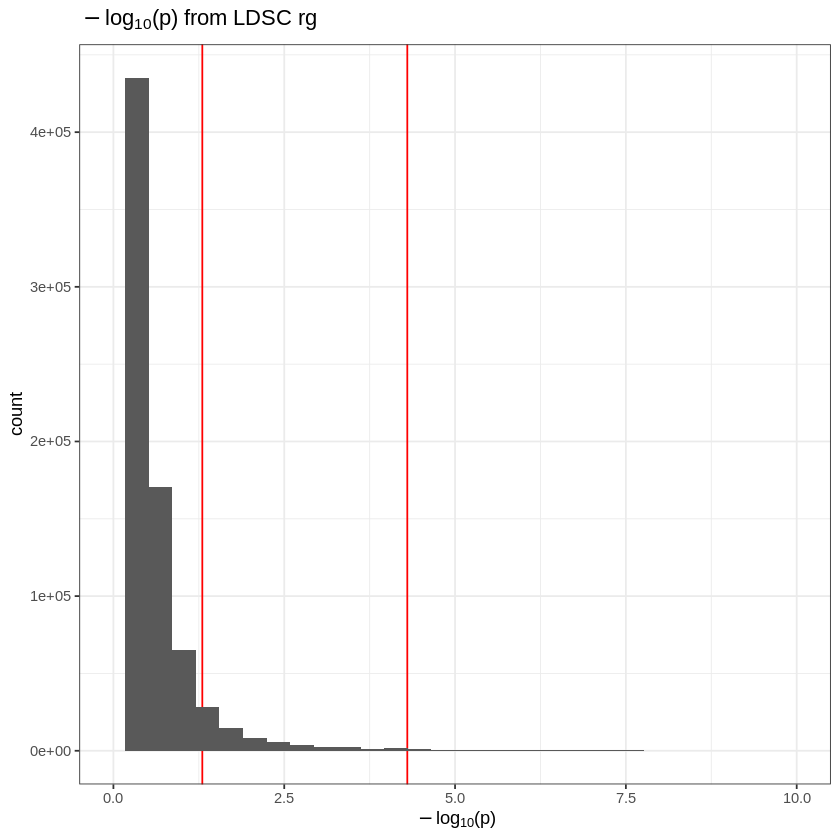

In [7]:
p_LDSC_p

In [8]:
df %>% dim() %>% print()
df %>% filter(p < 5e-2) %>% dim() %>% print()
df %>% filter(p < 5e-5) %>% dim() %>% print()


[1] 1084259      12
[1] 64124    12
[1] 6511   12


In [9]:
df %>% filter(p < 5e-2) %>% pull(phenocode) %>% unique() %>% length()
df %>% filter(p < 5e-2) %>% pull(GBE_ID) %>% unique() %>% length()

[1] 848

[1] 765

In [10]:
df %>% filter(p < 5e-5) %>% pull(phenocode) %>% unique() %>% length()
df %>% filter(p < 5e-5) %>% pull(GBE_ID) %>% unique() %>% length()

[1] 289

[1] 292

In [11]:
df %>% filter(p < 5e-4) %>% pull(rg) %>% abs() %>% max()

[1] 1.609

In [12]:
p_LDSC_rg <- df %>% filter(p < 5e-5) %>%
ggplot(aes(x=abs(rg))) +
# geom_vline(xintercept=-log10(0.05), color='red')+
geom_histogram(bins=30) +
theme_bw() +
xlim(0, 1.61) +
labs(
    title=latex2exp::TeX('Distribution of the estimated LDSC rg ($p < 10^{-4}$)'),
    x='abs(rg)'
)


Warning message:
“Removed 2 rows containing missing values (geom_bar).”


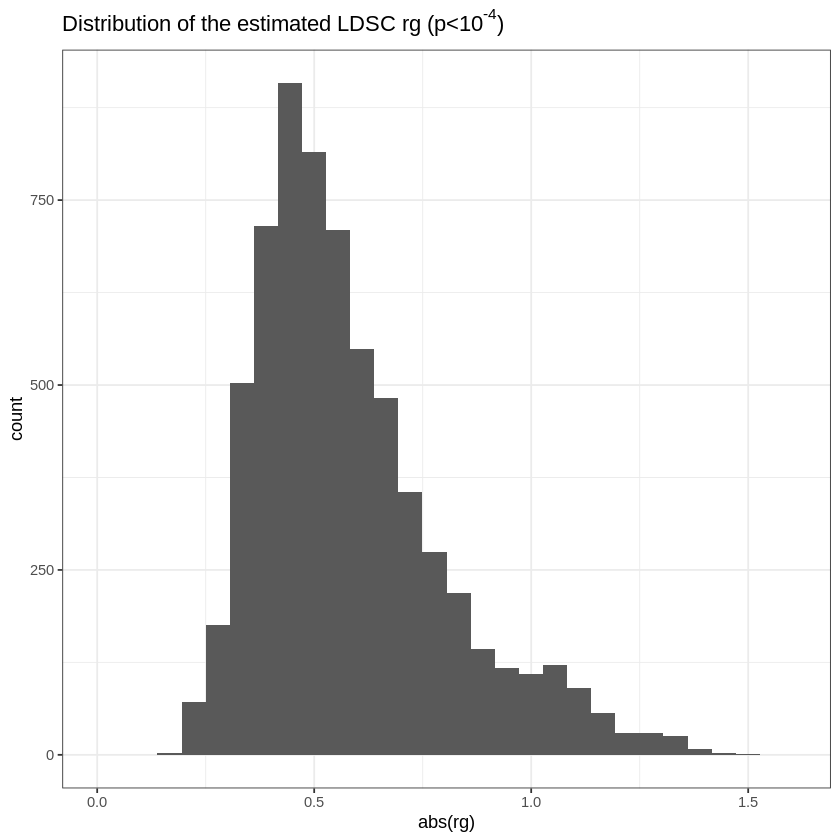

In [13]:
p_LDSC_rg

In [14]:
df %>% filter(p < 5e-5) %>%
left_join(
    GBE_names_df %>%
    select(GBE_ID, GBE_N, GBE_short_name),
    by='GBE_ID'
) %>%
left_join(
FinnGen_df %>%
    rename(
        'FinnGen_name'='name',
        'FinnGen_category'='category',
        'FinnGen_n_cases'='n_cases',
        'FinnGen_n_controls'='n_controls'
    ),
    by='phenocode'
) %>%
arrange(phenocode, p) %>%
mutate(Note = '') %>%
select(
    phenocode, GBE_ID,
    FinnGen_name, GBE_short_name, 
    rg, se, z, p,
    GBE_N, FinnGen_n_cases, FinnGen_n_controls, FinnGen_category,
    h2_obs, h2_obs_se, h2_int, h2_int_se, gcov_int, gcov_int_se,
    Note
) -> annot_df


In [15]:
annot_df %>%
rename('#phenocode' = 'phenocode') %>%
fwrite(out_f, sep='\t', na = "NA", quote=F)


In [16]:
g <- gridExtra::arrangeGrob(p_LDSC_p, p_LDSC_rg, ncol=2)


Warning message:
“Removed 922 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


In [17]:
ggsave(plot_f, g, width = 12, height=6)

In [18]:
plot_f

[1] "11_LDSC_rg_dist.png"

In [19]:
out_f

[1] "/oak/stanford/groups/mrivas/public_data/summary_stats/finngen_r3/UKB_WB_rg.20200722-093650.filtered.tsv"

In [20]:
sprintf('gdrive upload -p 1iyIXAk3woYnYPqCLuKmS86j31g4tB9rA %s', out_f)

[1] "gdrive upload -p 1iyIXAk3woYnYPqCLuKmS86j31g4tB9rA /oak/stanford/groups/mrivas/public_data/summary_stats/finngen_r3/UKB_WB_rg.20200722-093650.filtered.tsv"